In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models      import Sequential
from tensorflow.keras.layers      import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks   import EarlyStopping
import shap

2025-06-30 14:51:44.136364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751295104.365071      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751295104.429570      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv('/kaggle/input/ag-news-topic-classification/training_data.csv')
print(df.head())


                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2


In [4]:
print(df.columns)

Index(['text', 'label'], dtype='object')


In [5]:
print(df['label'].value_counts())

label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64


In [6]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(120000, 2)

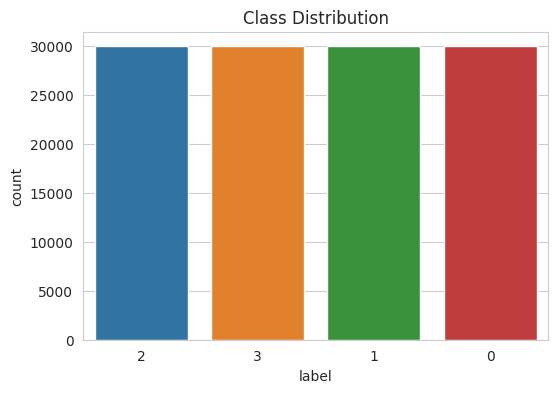

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title("Class Distribution")
plt.xticks()
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


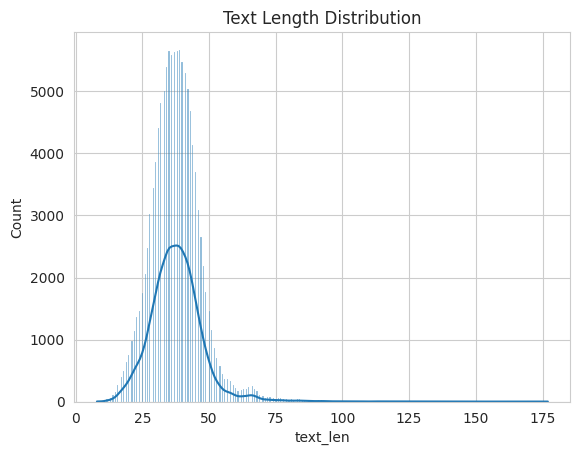

In [10]:
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_len'], kde=True)
plt.title("Text Length Distribution")
plt.show()

In [11]:
import re, string

def clean(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean'] = df['text'].astype(str).apply(clean)


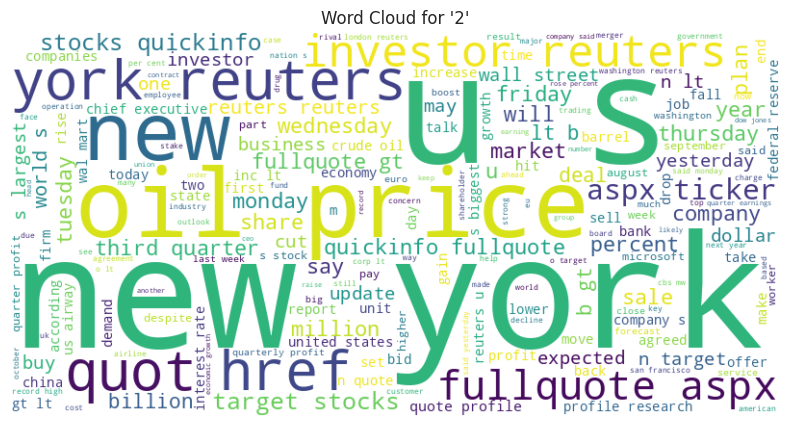

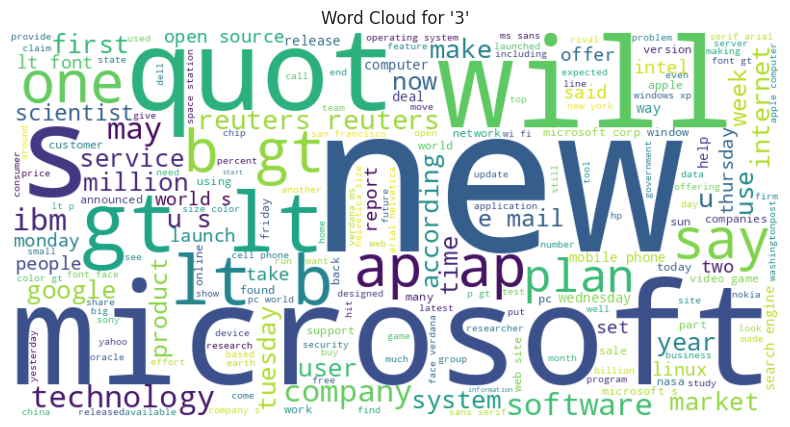

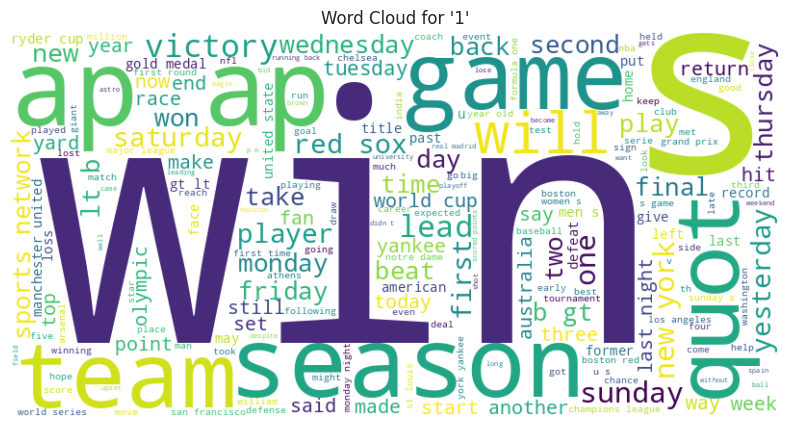

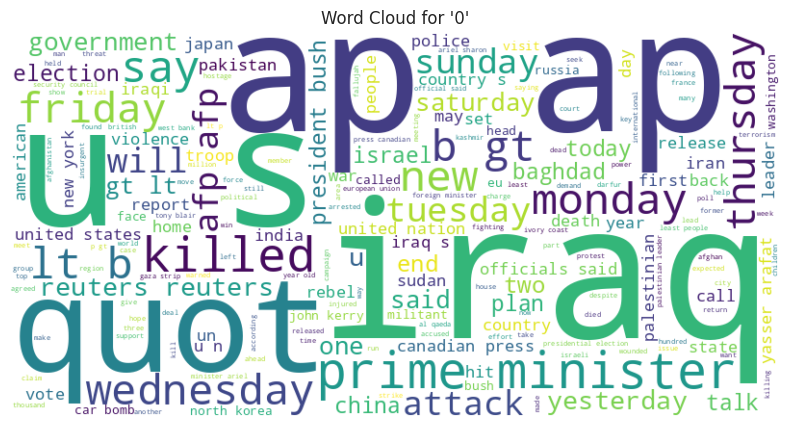

In [12]:
from wordcloud import WordCloud

for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['clean'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for '{label}'")
    plt.show()

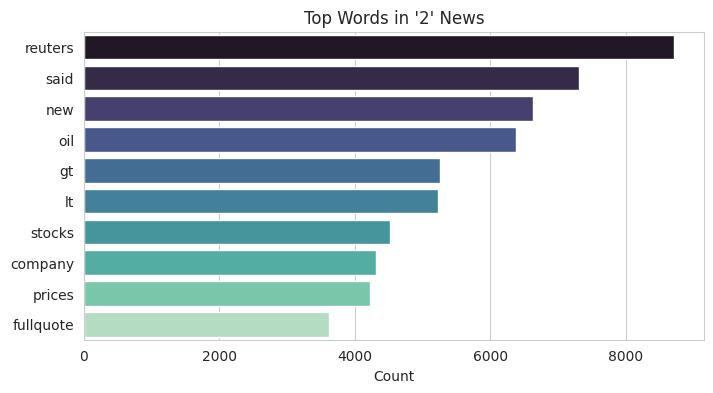

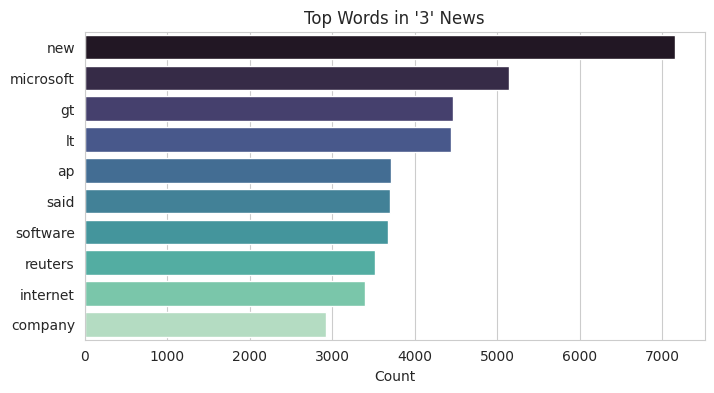

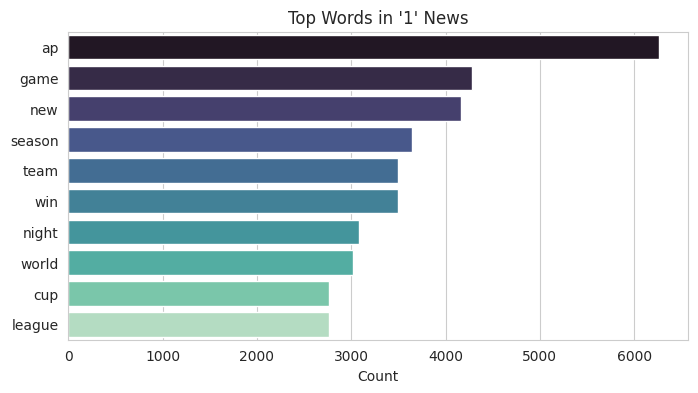

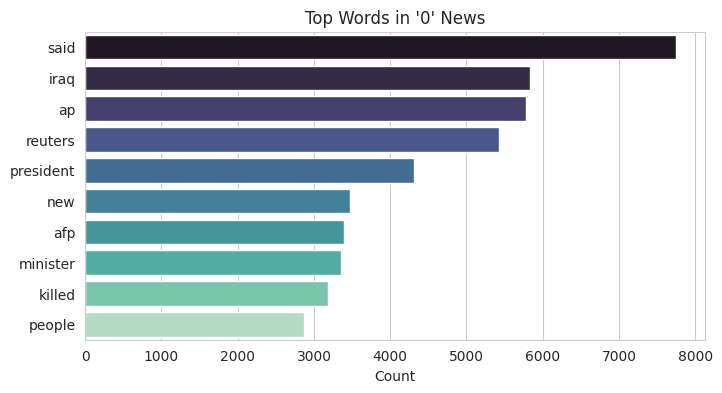

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_counts = vectorizer.fit_transform(df['clean'])
words = vectorizer.get_feature_names_out()

# Add to df
X_counts_df = pd.DataFrame(X_counts.toarray(), columns=words)
X_counts_df['label'] = df['label'].values

# Top 10 words per class
for label in df['label'].unique():
    label_df = X_counts_df[X_counts_df['label'] == label].drop('label', axis=1)
    top_words = label_df.sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_words.values, y=top_words.index, palette='mako')
    plt.title(f"Top Words in '{label}' News")
    plt.xlabel("Count")
    plt.show()


In [14]:

from sklearn.preprocessing import LabelEncoder
# Label encoding
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Train/Test split
X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    df['clean'], df['label_encoded'], test_size=0.2, stratify=df['label_encoded'], random_state=42)


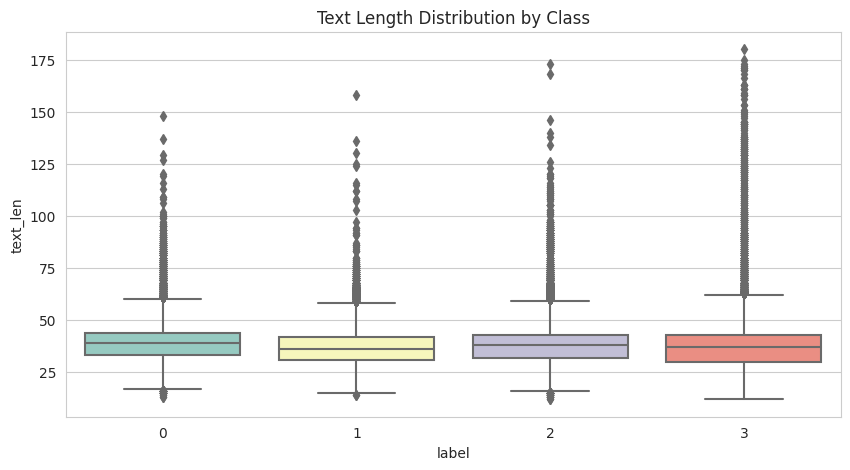

In [15]:
df['text_len'] = df['clean'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='label', y='text_len', palette='Set3')
plt.title("Text Length Distribution by Class")
plt.show()


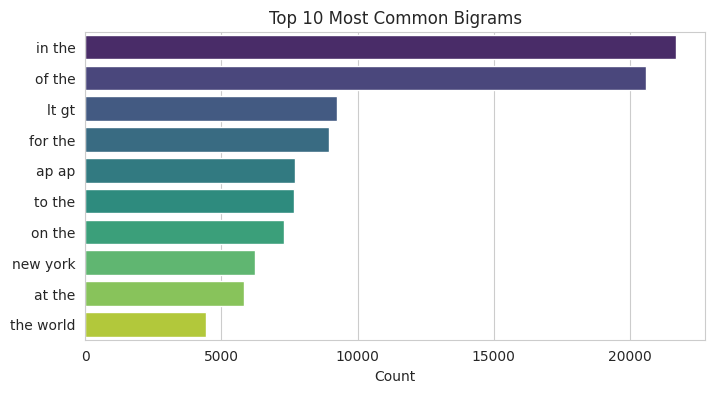

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,2), max_features=20)
X_ngrams = cv.fit_transform(df['clean'])
top_ngrams = np.asarray(cv.get_feature_names_out())

counts = X_ngrams.sum(axis=0).A1
sorted_idx = np.argsort(counts)[::-1]
top_counts = counts[sorted_idx][:10]
top_ngrams = top_ngrams[sorted_idx][:10]

plt.figure(figsize=(8, 4))
sns.barplot(x=top_counts, y=top_ngrams, palette='viridis')
plt.title("Top 10 Most Common Bigrams")
plt.xlabel("Count")
plt.show()


In [17]:
# Tokenizer
MAX_VOCAB = 30000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_txt)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_txt), maxlen=MAX_LEN, padding='post')
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test_txt), maxlen=MAX_LEN, padding='post')


In [18]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(X_train_seq, y_train,
                    validation_split=0.1,
                    epochs=10,
                    batch_size=256,
                    callbacks=[early_stop])


I0000 00:00:1751295165.074633      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1751295171.440397      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


338/338 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.6403 - loss: 0.8166 - val_accuracy: 0.9158 - val_loss: 0.2690
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9345 - loss: 0.2250 - val_accuracy: 0.9166 - val_loss: 0.2754
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9532 - loss: 0.1617 - val_accuracy: 0.9125 - val_loss: 0.2982
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9617 - loss: 0.1255 - val_accuracy: 0.9093 - val_loss: 0.3470


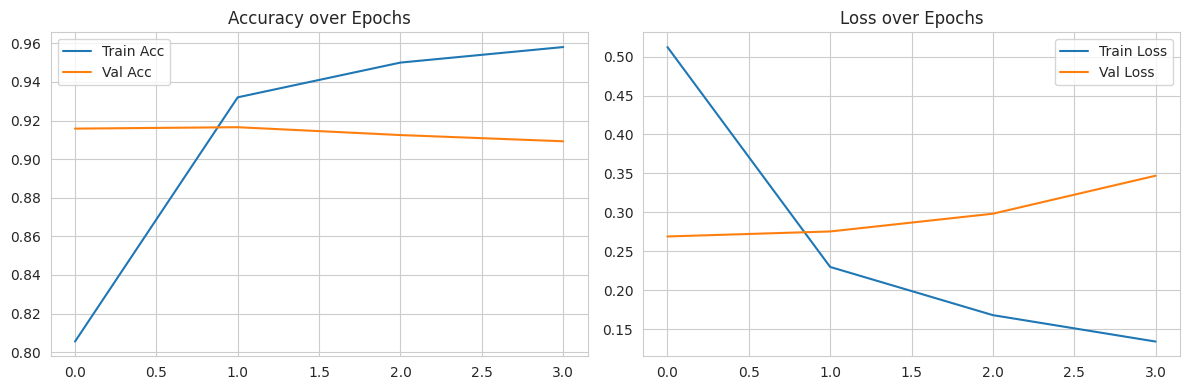

In [19]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


✅ Test Accuracy: 0.9192

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      6000
           1       0.96      0.98      0.97      6000
           2       0.89      0.89      0.89      6000
           3       0.89      0.90      0.90      6000

    accuracy                           0.92     24000
   macro avg       0.92      0.92      0.92     24000
weighted avg       0.92      0.92      0.92     24000



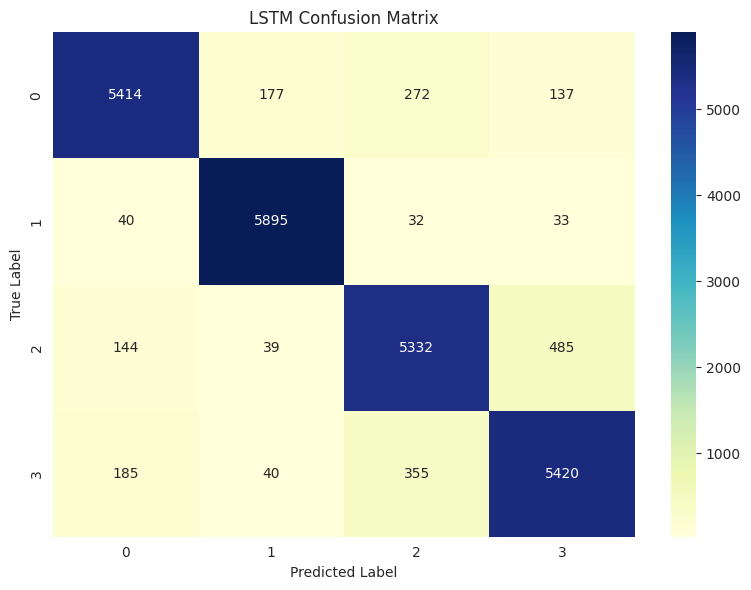

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_lstm = np.argmax(model.predict(X_test_seq, verbose=0), axis=1)

# Accuracy
acc = accuracy_score(y_test, y_pred_lstm)
print(f"✅ Test Accuracy: {acc:.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_lstm, target_names=list(map(str, le.classes_))))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=list(map(str, le.classes_)),
            yticklabels=list(map(str, le.classes_)))
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_scheduler
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [28]:
df = pd.read_csv("/kaggle/input/ag-news-topic-classification/training_data.csv")
df['text'] = df['text'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_encoded'], test_size=0.2, stratify=df['label_encoded'], random_state=42
)


In [23]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AGNewsDataset(X_train, y_train, tokenizer)
test_dataset  = AGNewsDataset(X_test, y_test, tokenizer)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(le.classes_)
).to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
epochs = 2
model.train()

for epoch in range(epochs):
    loop = tqdm(train_loader, leave=True)
    total_loss = 0

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())
    
    print(f"✅ Epoch {epoch+1} complete. Avg loss: {total_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 6000/6000 [10:36<00:00,  9.42it/s, loss=0.178]  


✅ Epoch 1 complete. Avg loss: 0.2487


Epoch 2: 100%|██████████| 6000/6000 [10:36<00:00,  9.43it/s, loss=0.0833] 

✅ Epoch 2 complete. Avg loss: 0.1502


📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9494    0.9403    0.9448      6000
           1     0.9812    0.9838    0.9825      6000
           2     0.9252    0.9070    0.9160      6000
           3     0.9130    0.9372    0.9249      6000

    accuracy                         0.9421     24000
   macro avg     0.9422    0.9421    0.9421     24000
weighted avg     0.9422    0.9421    0.9421     24000



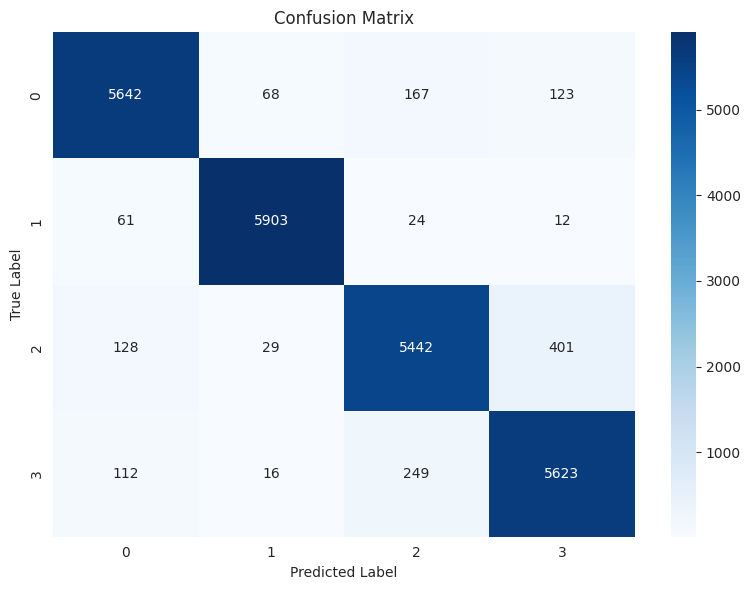

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure predicted and true labels are NumPy arrays
y_pred = np.array(all_preds)
y_true = np.array(all_labels)

# Ensure target names are strings (avoid "int has no len()" error)
if hasattr(le, 'classes_') and isinstance(le.classes_[0], (int, np.integer)):
    target_names = le.inverse_transform(np.unique(y_true)).astype(str).tolist()
else:
    target_names = le.classes_.tolist()

# 💬 Print classification report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# 🔷 Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
